<a href="https://colab.research.google.com/github/collect-intel/osccai-simulation/blob/main/notebooks/osccai_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OSCCAI Simulation Notebook

## Usage Instructions

This notebook simulates output from an Open Source Collective Constitutional AI (OSCCAI) tool.
You will need an OpenAI API key to run this notebook. Set it as an environment variable or enter it when prompted.

If running in Google Colab: this should already work with the notebook, but if not you can add your own `OPENAI_API_KEY` as a Secret on the left menubar.

**Running:** Select **Runtime** > **Run all**. Step #4: *User Input Collection* will prompt you for input about the community if the `USE_DEFAULT_COMMUNITY` flag below is set to `False`. Otherwise, the notebook will run through using a default community input.

**LLM Caching:**
This notebook makes use of caching to save on API usage when running the same API requests multiple times. Running this notebook through to the end will save an llm_cache file locally. You can upload this file from a previous session when prompted to restore this cache.

**Required Setup:**
- Set your OpenAI API key:
  - Option 1: Set as an environment variable or Google Colab Secret `OPENAI_API_KEY`
  - Option 2: Enter it when prompted in the notebook

In [1]:
# Define flags to control whether to use default inputs to see this run without requiring input
USE_DEFAULT_DATA = True
USE_DEFAULT_COMMUNITY = True

# Default values used when USE_DEFAULT_COMMUNITY = True
DEFAULT_NUM_SUBGROUPS = 3
DEFAULT_NUM_PARTICIPANTS = 100

## 1. Setup and Imports

In [2]:
# Uncomment and run this cell to install required packages
!pip install numpy pandas matplotlib openai tenacity asyncio nest_asyncio kneed

In [3]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from getpass import getpass
from IPython.display import display, Markdown
import pandas as pd
import numpy as np
from scipy.stats import beta, nbinom
import random
from openai import OpenAI
import openai

# Try to import from google.colab if available, otherwise use a fallback
try:
    from google.colab import files, userdata
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

    # Fallback function for file upload in Jupyter Notebook
    def upload_files():
        from ipywidgets import FileUpload
        from IPython.display import display

        uploader = FileUpload(accept='.csv', multiple=False)
        display(uploader)

        def on_upload_change(change):
            if change['type'] == 'change' and change['name'] == 'value':
                filename = list(change['new'].keys())[0]
                content = change['new'][filename]['content']
                with open(filename, 'wb') as f:
                    f.write(content)
                print(f"Uploaded file: {filename}")

        uploader.observe(on_upload_change, names='value')
        return uploader

# Set up OpenAI API key
if os.getenv("OPENAI_API_KEY"):
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
elif IN_COLAB and userdata.get('OPENAI_API_KEY'):
    # Add OPENAI_API_KEY as secret in google colab to skip manual entry
    client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
else:
    client = OpenAI(api_key=getpass("Please enter your OpenAI API key: "))

In [ ]:
# Use cache to efficiently store and reuse LLM responses
import hashlib
from functools import lru_cache
import functools

# Create a cache dictionary
llm_cache = {}

# generate cache key for prompts and responses, or functions and return results
def generate_cache_key(item, item_type='prompt', add_context=None):
    if item_type == 'prompt':
        key_string = f"{item}"
    elif item_type == 'function':
        func_name, args, kwargs = item
        args_str = ','.join(map(str, args))
        kwargs_str = ','.join(f"{k}={v}" for k, v in kwargs.items())
        key_string = f"{func_name}:{args_str}:{kwargs_str}"

    if add_context:
        key_string += f":{add_context}"

    return hashlib.md5(key_string.encode()).hexdigest()

## 2. Data Upload and Preprocessing

In [ ]:
import pandas as pd
import requests
from io import StringIO

# Default files if Default flag is True
DATA_FILE_URL = "https://raw.githubusercontent.com/collect-intel/osccai-simulation/refs/heads/main/data/ccai_polis_data_voters.csv"
COMMUNITY_FILE_URL = "https://raw.githubusercontent.com/collect-intel/osccai-simulation/refs/heads/llm-simulation/data/simulation_community_inputs.json"
LLM_CACHE_FILE_URL = "https://raw.githubusercontent.com/collect-intel/osccai-simulation/refs/heads/llm-simulation/data/llm_cache.json"

# Function to curl the CSV from GitHub
def curl_github_file(url):
    response = requests.get(url)
    return response.text if response.status_code == 200 else None

# Load baseline LLM cache
print("Attempting to load baseline LLM cache from GitHub...")
baseline_cache_json = curl_github_file(LLM_CACHE_FILE_URL)
if baseline_cache_json:
    baseline_llm_cache = json.loads(baseline_cache_json)
    print(f"Loaded {len(baseline_llm_cache)} items into baseline LLM cache")
else:
    print("Failed to load baseline LLM cache. Proceeding without it.")
    baseline_llm_cache = {}

# Get actual data to base distributions on
if USE_DEFAULT_DATA:
    print("Attempting to load data from GitHub...")
    csv_content = curl_github_file(DATA_FILE_URL)
    if csv_content:
        data = pd.read_csv(StringIO(csv_content))
    else:
        print("Failed to load default data. Please upload manually.")
        USE_DEFAULT_DATA = False

if not USE_DEFAULT_DATA:
    print("Please upload your Polis data CSV file.")
    if IN_COLAB:
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
    else:
        uploader = upload_files()
        # Wait for the user to upload a file
        while not uploader.value:
            pass
        filename = list(uploader.value.keys())[0]

    # Load the uploaded CSV into a DataFrame
    data = pd.read_csv(filename)

# Verify that data was loaded
if data is not None:
    print("Data loaded successfully.")
    print(f"Shape of the data: {data.shape}")
else:
    print("Failed to load data. Please check your input or try uploading manually.")



# Load community inputs
print("Attempting to load community inputs from GitHub...")
community_json = curl_github_file(COMMUNITY_FILE_URL)
community_data_list = json.loads(community_json)
if community_data_list:
    print("Community inputs loaded successfully.")
else:
    print("Failed to load community inputs. Will prompt for manual input.")
    USE_DEFAULT_COMMUNITY = False

Attempting to load baseline LLM cache from GitHub...
Loaded 50 items into baseline LLM cache
Attempting to load data from GitHub...
Data loaded successfully.
Shape of the data: (1002, 282)
Attempting to load community inputs from GitHub...
Community inputs loaded successfully.


In [ ]:
# Calculate additional metrics

# Calculate pass votes per participant
data['n-pass'] = data['n-votes'] - (data['n-agree'] + data['n-disagree'])

# Calculate % agree, % disagree, and % pass per participant
data['% agree'] = data['n-agree'] / data['n-votes']
data['% disagree'] = data['n-disagree'] / data['n-votes']
data['% pass'] = data['n-pass'] / data['n-votes']

## 3. Define Simulation Functions

In [ ]:
# cache results from simulation functions to make idempotent
def cache_result(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        data_context = DATA_FILE_URL if USE_DEFAULT_DATA else 'custom_data'
        cache_key = generate_cache_key((func.__name__, args, kwargs), item_type='function', add_context=data_context)
        if cache_key in llm_cache:
            print(f"Using cached result for {func.__name__}")
            return llm_cache[cache_key]
        result = func(*args, **kwargs)
        llm_cache[cache_key] = result
        return result
    return wrapper

In [ ]:
def fit_beta_distribution(data):
    """Fit a beta distribution to the given data."""
    data_cleaned = data.clip(lower=0.001, upper=0.999)
    a, b, _, _ = beta.fit(data_cleaned, floc=0, fscale=1)
    return a, b

def fit_negative_binomial(data):
    """Fit a negative binomial distribution to the given data."""
    mean = data.mean()
    var = data.var()
    n = (mean ** 2) / (var - mean) if var > mean else 10
    p = mean / (mean + n)
    return n, p

@cache_result
def calculate_statements_per_participant(num_participants):
    """Calculate the number of statements per participant based on actual data."""
    fattening_factor = 3 # fatten the right tail of the skew
    max_statements = 20
    # Add 1 to all values in the actual data to shift up any 0's to 1 minimum
    n_comments = data['n-comments'] + 1
    n, p = fit_negative_binomial(n_comments)

    # Adjust parameters to fatten the tail
    adjusted_n = n / fattening_factor
    adjusted_p = adjusted_n / (adjusted_n + n_comments.mean())

    # Generate samples from the adjusted negative binomial distribution
    samples = np.random.negative_binomial(n=adjusted_n, p=adjusted_p, size=num_participants)

    # Ensure at least 1 statement per participant and cap at max_statements
    return [min(max(1, sample), max_statements) for sample in samples]

@cache_result
def sample_statements_per_participant(num_participants):
    """Sample the number of statements per participant directly from actual data."""
    max_statements = 20

    # Ensure n-comments has at least 1 comment per participant
    n_comments = np.maximum(data['n-comments'], 1)

    # Sample with replacement from the actual data
    samples = np.random.choice(n_comments, size=num_participants, replace=True)

    # Cap at max_statements
    return [min(sample, max_statements) for sample in samples]

@cache_result
def calculate_votes_per_participant(num_participants, max_statements):
    """Calculate the number of votes per participant based on actual data, capped by max_statements."""
    n_votes = data['n-votes']
    n, p = fit_negative_binomial(n_votes)
    return [min(max(np.random.negative_binomial(n, p), 1), max_statements) for _ in range(num_participants)]

@cache_result
def calculate_vote_distribution_per_participant(num_participants):
    """Calculate the vote distribution per participant based on actual data."""
    agree_a, agree_b = fit_beta_distribution(data['% agree'])
    disagree_a, disagree_b = fit_beta_distribution(data['% disagree'])

    distributions = []
    for _ in range(num_participants):
        agree = np.random.beta(agree_a, agree_b)
        disagree = np.random.beta(disagree_a, disagree_b)
        pass_prob = max(0, 1 - (agree + disagree))
        total = agree + disagree + pass_prob
        distributions.append([round(agree/total, 3), round(disagree/total, 3), round(pass_prob/total, 3)])

    return distributions

## 3.1 Define OpenAI Functions

In [ ]:
import time
import json
from tenacity import retry, stop_after_attempt, wait_random_exponential
import traceback

@retry(wait=wait_random_exponential(min=1, max=10), stop=stop_after_attempt(3))
def get_openai_completion(prompt, add_context=None):
    """Sends a prompt to the OpenAI API and returns the completion, using cache if available."""
    cache_key = generate_cache_key(prompt, item_type='prompt', add_context=add_context)

    if cache_key in llm_cache:
        print("Using cached response")
        return llm_cache[cache_key]

    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are an assistant that outputs JSON-formatted data."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7
        )
        completion = response.choices[0].message.content

        # Cache the response
        llm_cache[cache_key] = completion
        print("Received response from OpenAI")
        return completion

    except Exception as e:
        if "RateLimitError" in str(type(e)):
          retry_after = int(e.headers.get("Retry-After", 10)) if getattr(e, 'headers', None) else 10
          print(f"Rate limit exceeded. Retrying after {retry_after} seconds.")
          time.sleep(retry_after)
          raise  # Re-raise the exception to stop execution
        else:
          print(f"Error during OpenAI API call: {e}")
          traceback.print_exc()
          raise  # Re-raise the exception to stop execution

import nest_asyncio
import asyncio
from asyncio import TimeoutError
from traceback import format_exc

# Apply nest_asyncio to run with an event loop already running in the notebook
nest_asyncio.apply()
from concurrent.futures import ThreadPoolExecutor

async def get_openai_completion_async(prompt):
    """Asynchronous version of get_openai_completion with caching."""
    print(f"Sending prompt to OpenAI asynchronously (length: {len(prompt)})")
    loop = asyncio.get_running_loop()
    try:
        with ThreadPoolExecutor() as pool:
            return await asyncio.wait_for(
                loop.run_in_executor(pool, get_openai_completion, prompt),
                timeout=120  # 120 seconds timeout
            )
    except TimeoutError:
        print("API call timed out")
        return None
    except Exception as e:
        print(f"Error during API call: {e}")
        traceback.print_exc()
        return None

# returns json string
async def get_openai_completion_chunked(prompt, data, chunk_size=10):
    print(f"Starting chunked completion with {len(data)} items, chunk size {chunk_size}")
    full_response = {"data": []}

    chunks = [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]
    print(f"Prepared {len(chunks)} chunks for processing")



    async def process_chunk(chunk_index, chunk):
        chunk_prompt = f"{prompt}\nProcess the following chunk:\n{json.dumps(chunk)}"
        try:
            response = await get_openai_completion_async(chunk_prompt)
            print(f"Received response for chunk {chunk_index + 1}")
            return response
        except Exception as e:
            print(f"Error processing chunk {chunk_index + 1}: {e}")
            traceback.print_exc()
            return None

    async_responses = await asyncio.gather(*[process_chunk(i, chunk) for i, chunk in enumerate(chunks)])

    for chunk_response in async_responses:
        if chunk_response:
            try:
                chunk_data = json.loads(chunk_response)
                full_response["data"].extend(chunk_data["data"])
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from chunk response: {e}")

    print(f"Processed {len(async_responses)} chunks")

    return full_response

# Example usage of get_openai_completion_chunked
async def process_data_async():
    # ... other code ...
    chunked_response = await get_openai_completion_chunked(prompt, data, chunk_size=10)
    # ... process chunked_response ...
# In the main execution:
# asyncio.run(process_data_async())

## 4. User Input Collection

In [ ]:
from ipywidgets import widgets

# Create a dictionary of community names and their data
community_dict = {c['community_name']: c for c in community_data_list}
community_names = list(community_dict.keys()) + ['Custom']

# Create dropdown for community selection
community_dropdown = widgets.Dropdown(
    options=community_names,
    description='Select Community:',
    value='Representative sample of US population'  # Set default
)

# Create input widgets for custom community
custom_name = widgets.Text(description='Community Name:')
custom_description = widgets.Textarea(description='Community Description:')
custom_goals = widgets.Textarea(description='Community Goals for AI Model:')

# Function to handle community selection
def on_community_change(change):
    if change['new'] == 'Custom':
        display(custom_name, custom_description, custom_goals)
    else:
        for widget in [custom_name, custom_description, custom_goals]:
            if widget.layout.display != 'none':
                widget.layout.display = 'none'

community_dropdown.observe(on_community_change, names='value')

# Display the dropdown
display(community_dropdown)

print("### Community Information Collection ###")
if USE_DEFAULT_COMMUNITY:
    selected_community = community_dict['Representative sample of US population']
    community_name = selected_community['community_name']
    community_description = selected_community['community_description']
    community_goals = selected_community['community_goals_for_ai_model']
    print(f"Using default community: {community_name}")
else:
    # Wait for user to make a selection
    # Note: In a Jupyter notebook, you might need to run this cell twice
    # Once to display the dropdown, and again after making a selection
    if community_dropdown.value == 'Custom':
        community_name = custom_name.value
        community_description = custom_description.value
        community_goals = custom_goals.value
    else:
        selected_community = community_dict[community_dropdown.value]
        community_name = selected_community['community_name']
        community_description = selected_community['community_description']
        community_goals = selected_community['community_goals_for_ai_model']

# Consolidate inputs into a single community description
full_community_description = f"{community_description}\nGoals: {community_goals}"

print("\n### Simulation Parameters Collection ###")
if USE_DEFAULT_COMMUNITY:
    num_subgroups = DEFAULT_NUM_SUBGROUPS
    num_participants = DEFAULT_NUM_PARTICIPANTS
    print(f"Using default values: {num_subgroups} subgroups, {num_participants} participants")
else:
    while True:
        try:
            num_subgroups = int(input(f"Enter the number of subgroups (G) [default: {DEFAULT_NUM_SUBGROUPS} ]: ") or f"{DEFAULT_NUM_SUBGROUPS}")
            if num_subgroups <= 0:
                raise ValueError("Number of subgroups must be positive.")
            break
        except ValueError as e:
            print(f"Invalid input: {e}")

    while True:
        try:
            num_participants = int(input(f"Enter the total number of participants (P) [default: {DEFAULT_NUM_PARTICIPANTS}]: ") or f"{DEFAULT_NUM_PARTICIPANTS}")
            if num_participants <= 0:
                raise ValueError("Number of participants must be positive.")
            break
        except ValueError as e:
            print(f"Invalid input: {e}")

statement_format = None
if not USE_DEFAULT_COMMUNITY:
    statement_format = input("Enter the statement format (default: 'The best response is one that...'): ").strip()
if not statement_format:
    statement_format = "The best response is one that..."

# Function to load LLM cache
def load_llm_cache(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)

# Initialize llm_cache with the baseline cache
llm_cache = baseline_llm_cache.copy()

# Ask if user wants to use an additional saved LLM cache
use_saved_cache = input("Do you want to use an additional saved LLM cache? (y/n): ").lower().strip() == 'y'
if use_saved_cache:
    if IN_COLAB:
        uploaded = files.upload()
        cache_file = list(uploaded.keys())[0]
    else:
        uploader = upload_files()
        while not uploader.value:
            pass
        cache_file = list(uploader.value.keys())[0]

    user_llm_cache = load_llm_cache(cache_file)
    # Merge user cache with baseline cache, giving priority to user cache
    llm_cache.update(user_llm_cache)
    print(f"Merged {len(user_llm_cache)} items from user cache into LLM cache")

print(f"Total items in LLM cache: {len(llm_cache)}")

Dropdown(description='Select Community:', index=1, options=('Second Life', 'Representative sample of US popula…

### Community Information Collection ###
Using default community: Representative sample of US population

### Simulation Parameters Collection ###
Using default values: 3 subgroups, 100 participants
Do you want to use an additional saved LLM cache? (y/n): y


Saving llm_cache (2).json to llm_cache (2) (2).json
Merged 101 items from user cache into LLM cache
Total items in LLM cache: 101


## 5. Simulation Setup Calculations

In [ ]:
def calculate_participants_per_group(num_subgroups, num_participants):
    """Distribute participants among groups with variability but no extreme disparities."""
    base = num_participants // num_subgroups
    remainder = num_participants % num_subgroups
    participants_per_group = [base] * num_subgroups
    for i in range(remainder):
        participants_per_group[i] += 1
    # Introduce slight variability
    for i in range(len(participants_per_group)):
        variation = np.random.randint(-base//10, base//10+1)
        participants_per_group[i] = max(1, participants_per_group[i] + variation)
    total_participants = sum(participants_per_group)
    # Adjust if total participants changed due to variability
    if total_participants != num_participants:
        difference = num_participants - total_participants
        for i in range(abs(difference)):
            index = i % num_subgroups
            if difference > 0:
                participants_per_group[index] += 1
            else:
                participants_per_group[index] = max(1, participants_per_group[index] - 1)
    return participants_per_group

participants_per_group = calculate_participants_per_group(num_subgroups, num_participants)
print(f"\nParticipants per group: {participants_per_group}")


Participants per group: [31, 33, 36]


## 6. LLM Interaction for Group and Participant Generation

In [ ]:
# Generate subgroups
subgroup_generation_prompt = f"""
You are tasked with creating realistic subgroups for a community simulation. Use the following information to generate detailed descriptions:

Community Description: {full_community_description}
Number of Subgroups: {num_subgroups}

For each subgroup:
1. Provide a 2-sentence description of the subgroup. This description must start with the words: "This group consists of individuals who..."

Ensure descriptions are diverse and realistic within the context of the community.

Return your response in the following JSON format:
{{"subgroups": [
    {{"description": "This group consists of individuals who <rest of description>"}},
    ...]
}}
"""

subgroup_generation_response = get_openai_completion(subgroup_generation_prompt)

try:
    subgroup_data = json.loads(subgroup_generation_response)
    subgroups = subgroup_data['subgroups']
    print("\nGenerated Subgroups:")
    print(json.dumps(subgroups, indent=4))
except json.JSONDecodeError as e:
    print(f"Error parsing JSON: {e}")
    subgroups = []

Received response from OpenAI

Generated Subgroups:
[
    {
        "description": "This group consists of individuals who are young adults, between the ages of 18-30, and are currently enrolled in higher education or recently graduated. They are tech-savvy, value social justice, and are interested in shaping the future of AI in line with ethical guidelines and inclusivity."
    },
    {
        "description": "This group consists of individuals who are middle-aged, between the ages of 40-60, with a diverse range of professional backgrounds. They are comfortable with technology but may not understand it deeply, and they value practicality, efficiency, and transparency in AI interactions."
    },
    {
        "description": "This group consists of individuals who are seniors aged 65 and above. They may not be familiar with technology but are interested in how AI can enhance their daily lives, particularly in areas such as healthcare, reminders for daily tasks, and communication with lo

In [ ]:
indexed_subgroup_data = [
    {
        "subgroup_index": i,
        "num_participants": num_participants,
        "description": subgroup['description']
    }
    for i, (subgroup, num_participants) in enumerate(zip(subgroups, participants_per_group))
]

async def generate_participants():
    participant_generation_prompt = """
    Generate unique, 1-sentence descriptions of individuals who could belong to the following subgroups:

    For each subgroup in the input data, generate the specified number of participant descriptions.
    Ensure descriptions are diverse and realistic within the context of the community.

    The description of each participant should take this form: "A <demographic description> who is <extended description of situation, personality, or goals>."
    Do not include the name of the participant.

    Return your response in the following JSON format:
    {"data": [{ "subgroup_index": 0, "participants": ["Participant 1 description", "Participant 2 description", ...] },
              { "subgroup_index": 1, "participants": [...] },
              ...]}
    """

    chunked_response = await get_openai_completion_chunked(
        participant_generation_prompt,
        indexed_subgroup_data,
        chunk_size=1  # Adjust this value as needed
    )

    return chunked_response

# Run the async function to generate participants
try:
    # This will work in both Jupyter and Colab
    loop = asyncio.get_event_loop()
    all_participants = loop.run_until_complete(generate_participants())
except RuntimeError:
    # Fallback for environments where get_event_loop() might fail
    all_participants = asyncio.run(generate_participants())


Starting chunked completion with 3 items, chunk size 1
Prepared 3 chunks for processing
Sending prompt to OpenAI asynchronously (length: 1153)
Sending prompt to OpenAI asynchronously (length: 1142)
Sending prompt to OpenAI asynchronously (length: 1135)
Received response from OpenAI
Received response for chunk 2
Received response from OpenAI
Received response for chunk 3
Received response from OpenAI
Received response for chunk 1
Processed 3 chunks


In [ ]:
# Combine subgroups by index from all_subgroups_data and participants from all_participants into group_data
group_data = {
    "subgroups": [
        {
            "description": subgroup_data['description'],
            "participants": next(item for item in all_participants['data'] if item["subgroup_index"] == subgroup_data["subgroup_index"])["participants"]
        }
        for subgroup_data in indexed_subgroup_data
    ]
}



print("\nGenerated Subgroups and Participants:")
print(json.dumps(group_data, indent=4))


Generated Subgroups and Participants:
{
    "subgroups": [
        {
            "description": "This group consists of individuals who are young adults, between the ages of 18-30, and are currently enrolled in higher education or recently graduated. They are tech-savvy, value social justice, and are interested in shaping the future of AI in line with ethical guidelines and inclusivity.",
            "participants": [
                "A 20-year-old Computer Science student who is passionate about incorporating AI in environmental sustainability.",
                "A recent graduate in Philosophy, aged 26, who is interested in the ethical implications of AI.",
                "A 22-year-old active social justice advocate majoring in Sociology, focusing on the societal impact of AI.",
                "A 28-year-old Psychology graduate who is curious about exploring the intersection of AI and human behavior.",
                "A young adult enrolled in an MBA program, aspiring to drive e

## 7. LLM Interaction for Statement Generation

In [ ]:
# Calculate the total number of participants
total_participants = sum(len(subgroup['participants']) for subgroup in group_data['subgroups'])

# Sample statements per participant - Ensure the number of samples matches the total number of participants
statements_per_participant = sample_statements_per_participant(total_participants)

# Create an iterator from statements_per_participant
statements_iter = iter(statements_per_participant)

# Prepare the data structure for chunked processing
chunkable_data = []
participant_id_counter = 1  # Initialize a counter for unique participant IDs

for subgroup_index, subgroup in enumerate(group_data['subgroups']):
    for participant in subgroup['participants']:
        chunkable_data.append({
            'participant_id': participant_id_counter,
            'subgroup_index': int(subgroup_index),
            'num_statements': int(next(statements_iter)),
            'participant': participant
        })
        participant_id_counter += 1  # Increment the counter for the next participant


In [ ]:
# Verify that all statements_per_participant values were used
if any(True for _ in statements_iter):
    print("Warning: Not all statements_per_participant values were used.")

# Prepare subgroup descriptions
subgroup_descriptions = [
    f"Subgroup {i}: {subgroup['description']}"
    for i, subgroup in enumerate(group_data['subgroups'])
]

statement_generation_prompt = f"""
Generate statements for a community AI model alignment survey. Use the following information:

Community Description: {full_community_description}
Statement Format: "{statement_format}"

Subgroup Descriptions:
{json.dumps(subgroup_descriptions, indent=2)}

For each participant in the input data, generate the specified number of statements that align with their subgroup and individual characteristics. Ensure statements are diverse and relevant to the community's goals.

The input data format is:
[participant_id, subgroup_index, number_of_statements_to_generate, participant_description]

Return your response in the following JSON format:
{{
    "data": [
        {{
            "participant_id": "<participant_id>",
            "statements": ["Statement 1", "Statement 2", ...]
        }},
        ...
    ]
}}
"""

async def generate_statements():
    chunked_response = await get_openai_completion_chunked(
        statement_generation_prompt,
        chunkable_data,
        chunk_size=10  # Adjust this value as needed
    )
    return chunked_response

# Run the async function to generate statements
try:
    # This will work in both Jupyter and Colab
    loop = asyncio.get_event_loop()
    all_statements = loop.run_until_complete(generate_statements())
except RuntimeError:
    # Fallback for environments where get_event_loop() might fail
    all_statements = asyncio.run(generate_statements())

# convert list of dict objects: [{"participant_id":<participant_id>, "statements":[<statements>]}] to a dict with keys: {<participant_id>:[<statements>],}
participant_statements = {item['participant_id']: item['statements'] for item in all_statements['data']}

try:
    print("\nGenerated Participant Statements:")
    print(json.dumps(participant_statements, indent=4))
except json.JSONDecodeError as e:
    print(f"Error parsing JSON: {e}")
    participant_statements = []

Starting chunked completion with 101 items, chunk size 10
Prepared 11 chunks for processing
Sending prompt to OpenAI asynchronously (length: 4192)
Sending prompt to OpenAI asynchronously (length: 4116)
Sending prompt to OpenAI asynchronously (length: 4112)
Sending prompt to OpenAI asynchronously (length: 4149)
Sending prompt to OpenAI asynchronously (length: 4122)
Sending prompt to OpenAI asynchronously (length: 4093)
Sending prompt to OpenAI asynchronously (length: 4112)
Sending prompt to OpenAI asynchronously (length: 4128)
Sending prompt to OpenAI asynchronously (length: 4133)
Sending prompt to OpenAI asynchronously (length: 4142)
Sending prompt to OpenAI asynchronously (length: 2543)
Received response from OpenAI
Received response for chunk 11
Received response from OpenAI
Received response for chunk 9
Received response from OpenAI
Received response for chunk 8
Received response from OpenAI
Received response for chunk 10
Received response from OpenAI
Received response for chunk 2
R

In [ ]:
# Verify that the number of statements per participant is consistent
print(statements_per_participant)
print([len(s) for s in participant_statements.values()])
print([i['num_statements'] for i in chunkable_data])
#skip: assert statements_per_participant == [len(s) for s in participant_statements.values()] == [len(i['statements']) for i in  all_statements['data']] == [i['num_statements'] for i in chunkable_data]


[3, 1, 1, 1, 1, 1, 1, 1, 20, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 1, 1, 1, 1, 1, 1, 1, 20, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[3, 1, 1, 1, 1, 1, 1, 1, 20, 1, 1, 1, 1, 4, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 2, 3, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 8. LLM Interaction for Vote Simulation

In [ ]:
print("Starting vote simulation process...")

# Prepare numbered statements list
statements_list = []
statement_id = 1
for participant_id, statements in participant_statements.items():
    for stmt in statements:
        statements_list.append({'statement_id': statement_id, 'text': stmt})
        statement_id += 1

print(f"Prepared {len(statements_list)} statements for {len(participant_statements)} participants")

numbered_statements_list = json.dumps(statements_list, indent=4)

# Prepare participants and assignments data
max_statements = len(statements_list)
votes_per_participant = calculate_votes_per_participant(len(participant_statements), max_statements)
vote_distributions = calculate_vote_distribution_per_participant(len(participant_statements))

print(f"Calculated votes per participant and vote distributions")

chunkable_data = []
for i, (participant_id, statements) in enumerate(participant_statements.items()):
    num_votes = votes_per_participant[i]
    available_statements = [s['statement_id'] for s in statements_list]
    assigned_statements = random.sample(available_statements, min(num_votes, len(available_statements)))
    chunkable_data.append({
        'participant_id': participant_id,
        'statements_assigned': assigned_statements,
        'vote_distribution': dict(zip(['agree', 'disagree', 'pass'], vote_distributions[i]))
    })

print(f"Prepared chunkable data for {len(chunkable_data)} participants")

vote_simulation_prompt = f"""
Simulate voting patterns for a community AI model alignment survey. Use the following information:

Community Description: {full_community_description}
Statements:
{numbered_statements_list}

For each participant in the input data, determine how they would likely vote on their assigned statements. Use the following voting options:
1 = Agree
-1 = Disagree
0 = Pass

Ensure that each participant's voting pattern closely matches their target vote distribution.

The input data format is:
[participant_id, statements_assigned, vote_distribution]

Return your response in the following JSON format:
{{
    "data": [
        {{
            "participant_id": "Unique identifier",
            "votes": {{"statement_id": vote, ...}}
        }},
        ...
    ]
}}
"""

print("Prepared vote simulation prompt")

async def simulate_votes():
    print("Starting vote simulation...")
    chunked_response = await get_openai_completion_chunked(
        vote_simulation_prompt,
        chunkable_data,
        chunk_size=4  # Adjust this value as needed
    )
    print("Completed vote simulation")
    return chunked_response

# Run the async function to simulate votes
print("Initiating async vote simulation...")
try:
    loop = asyncio.get_event_loop()
    vote_simulation_response = loop.run_until_complete(simulate_votes())
    print("Async vote simulation completed")
except RuntimeError:
    print("RuntimeError occurred, falling back to asyncio.run()")
    vote_simulation_response = asyncio.run(simulate_votes())
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    vote_simulation_response = None

if vote_simulation_response:
    try:
        vote_data = vote_simulation_response['data']
        # make sure vote statement_ids are ints
        participant_votes = {item['participant_id']: {int(stmt_id): vote for stmt_id, vote in item['votes'].items()} for item in vote_data}
        # participant_votes = { <participant_id>: {<statement_id>: <vote>, ...}, ... }
        print("\nSimulated Votes:")
        print(json.dumps(participant_votes, indent=4))
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error processing vote data: {e}")
        participant_votes = {}
else:
    print("No vote simulation response received")
    participant_votes = {}

print("Vote simulation process completed")

Starting vote simulation process...
Prepared 147 statements for 101 participants
Calculated votes per participant and vote distributions
Prepared chunkable data for 101 participants
Prepared vote simulation prompt
Initiating async vote simulation...
Starting vote simulation...
Starting chunked completion with 101 items, chunk size 4
Prepared 26 chunks for processing
Sending prompt to OpenAI asynchronously (length: 28260)
Sending prompt to OpenAI asynchronously (length: 28415)
Sending prompt to OpenAI asynchronously (length: 28404)
Sending prompt to OpenAI asynchronously (length: 28379)
Sending prompt to OpenAI asynchronously (length: 28410)
Sending prompt to OpenAI asynchronously (length: 28331)
Sending prompt to OpenAI asynchronously (length: 28291)
Sending prompt to OpenAI asynchronously (length: 28321)
Sending prompt to OpenAI asynchronously (length: 28428)
Sending prompt to OpenAI asynchronously (length: 28336)
Sending prompt to OpenAI asynchronously (length: 28332)
Sending prompt 

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tenacity/__init__.py", line 478, in __call__
    result = fn(*args, **kwargs)
  File "<ipython-input-56-383e3e72105a>", line 16, in get_openai_completion
    response = client.chat.completions.create(
  File "/usr/local/lib/python3.10/dist-packages/openai/_utils/_utils.py", line 274, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/openai/resources/chat/completions.py", line 704, in create
    return self._post(
  File "/usr/local/lib/python3.10/dist-packages/openai/_base_client.py", line 1270, in post
    return cast(ResponseT, self.request(cast_to, opts, stream=stream, stream_cls=stream_cls))
  File "/usr/local/lib/python3.10/dist-packages/openai/_base_client.py", line 947, in request
    return self._request(
  File "/usr/local/lib/python3.10/dist-packages/openai/_base_client.py", line 1036, in _request
    return self._retry_request(
  File "/usr/local/lib/p

Received response from OpenAI
Received response for chunk 19
Received response from OpenAI
Received response for chunk 14
Received response from OpenAI
Received response for chunk 21
Received response from OpenAI
Received response for chunk 12
Received response from OpenAI
Received response for chunk 15
Processed 26 chunks
Completed vote simulation
Async vote simulation completed

Simulated Votes:
{
    "1": {
        "70": 1,
        "88": 1,
        "119": 0,
        "34": 1,
        "115": -1,
        "111": 1,
        "26": 1,
        "74": 1,
        "142": 0,
        "39": 1,
        "48": 0,
        "110": 1,
        "67": 1,
        "93": 0,
        "16": 1
    },
    "2": {
        "107": 1,
        "138": 1,
        "117": 1,
        "60": 0,
        "122": 1,
        "65": 1,
        "115": 1,
        "54": -1,
        "64": 1,
        "3": 1,
        "77": 0,
        "58": 1,
        "97": 1,
        "80": 1
    },
    "3": {
        "76": 1,
        "21": -1,
        "66":

## 9. Vote Matrix Generation

In [ ]:
# Create empty matrix (rows = participants, columns = statements)
participant_ids = list(participant_votes.keys())
statement_ids = sorted(set(stmt_id for votes in participant_votes.values() for stmt_id in votes))

vote_matrix = pd.DataFrame(index=participant_ids, columns=statement_ids)

# Populate matrix with votes
for participant_id, votes in participant_votes.items():
    for stmt_id, vote_value in votes.items():
        vote_matrix.at[participant_id, stmt_id] = vote_value

# Convert data types
vote_matrix = vote_matrix.apply(pd.to_numeric, errors='coerce')

## 10. Results Visualization and Analysis

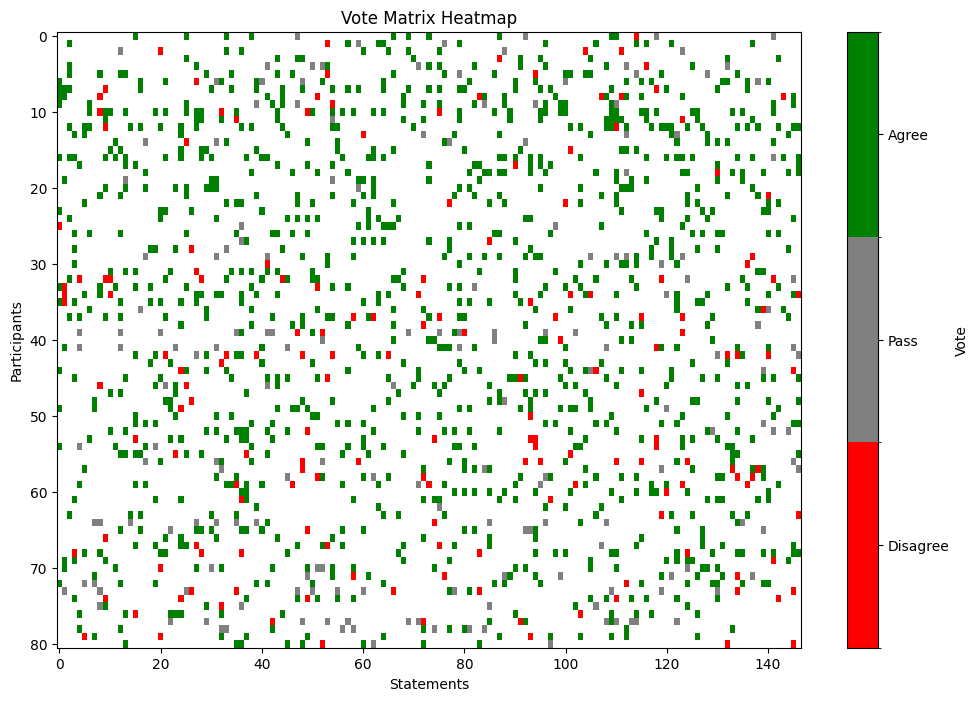


### Vote Distribution Statistics ###
 1.0    1105
 0.0     175
-1.0     171
Name: count, dtype: int64
NaN (No Vote): 10456


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create a custom colormap with white for NaN values
colors = ['red', 'gray', 'green', 'white']
cmap = mcolors.ListedColormap(colors[:-1])
cmap.set_bad(color=colors[-1])  # Set NaN color to white

# Create custom normalization
bounds = [-1.5, -0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(12, 8))

# Use masked array to handle NaN values
masked_data = np.ma.masked_invalid(vote_matrix)

plt.imshow(masked_data, aspect='auto', cmap=cmap, norm=norm, interpolation='none')

# Create a custom colorbar
cbar = plt.colorbar(ticks=[-1, 0, 1])
cbar.set_ticklabels(['Disagree', 'Pass', 'Agree'])
cbar.set_label('Vote')

plt.xlabel('Statements')
plt.ylabel('Participants')
plt.title('Vote Matrix Heatmap')
plt.show()

# Calculate and display vote distribution statistics
vote_counts = vote_matrix.stack().value_counts()
print("\n### Vote Distribution Statistics ###")
print(vote_counts)

# Add count of NaN values
nan_count = vote_matrix.isna().sum().sum()
print(f"NaN (No Vote): {nan_count}")

In [ ]:
# Convert vote_matrix to a list of lists
vote_matrix_list = vote_matrix.values.tolist()

# Replace NaN values with None
vote_matrix_list = [[None if pd.isna(value) else int(value) for value in row] for row in vote_matrix_list]

# Print the result
print("Vote matrix as a list of lists:")
print("[")
for row in vote_matrix_list:
    print(f"    {row},")
print("]")

Vote matrix as a list of lists:
[
    [None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, None, None, None, None, None, None, None, None, None, 1, None, None, None, None, None, None, None, 1, None, None, None, None, 1, None, None, None, None, None, None, None, None, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, None, None, 1, None, None, None, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, None, None, None, None, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 1, 1, None, None, None, -1, None, None, None, 0, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 0, None, None, None, None, None],
    [None, None, 1, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, 

## 12. Impute Missing Votes (Using Jaccard Similarity)

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict

def jaccard_similarity(vote_matrix):
    def jaccard_distance(a, b):
        a_valid = ~np.isnan(a)
        b_valid = ~np.isnan(b)
        common_valid = a_valid & b_valid

        if not np.any(common_valid):
            return 1.0  # Maximum distance if no common valid votes

        a_agree = set(np.where((a == 1) & common_valid)[0])
        b_agree = set(np.where((b == 1) & common_valid)[0])
        a_disagree = set(np.where((a == -1) & common_valid)[0])
        b_disagree = set(np.where((b == -1) & common_valid)[0])

        j_agree = len(a_agree & b_agree) / len(a_agree | b_agree) if len(a_agree | b_agree) > 0 else 0
        j_disagree = len(a_disagree & b_disagree) / len(a_disagree | b_disagree) if len(a_disagree | b_disagree) > 0 else 0

        return 1 - (j_agree + j_disagree) / 2

    # Calculate distance matrix
    distance_matrix = squareform(pdist(vote_matrix.fillna(np.nan), metric=jaccard_distance))
    # Convert to similarity matrix
    similarity_matrix = 1 - distance_matrix
    return similarity_matrix

def impute_missing_values_jaccard_similarity(vote_matrix, n_neighbors=5):
    # Convert vote_matrix to numpy array
    votes = vote_matrix.values

    # Calculate similarity matrix
    similarity_matrix = jaccard_similarity(vote_matrix)

    # Impute missing values
    imputed_votes = np.copy(votes)
    for i in range(votes.shape[0]):
        missing_indices = np.where(np.isnan(votes[i]))[0]
        if len(missing_indices) == 0:
            continue

        similar_indices = np.argsort(similarity_matrix[i])[::-1]  # Indices of participants sorted by similarity
        for j in missing_indices:
            sim_votes = []
            sim_weights = []
            for idx in similar_indices:
                if not np.isnan(votes[idx, j]) and idx != i:
                    sim_votes.append(votes[idx, j])
                    sim_weights.append(similarity_matrix[i, idx])
                if len(sim_votes) >= n_neighbors:
                    break
            if sim_votes:
                # Check if sim_weights sum to zero, for edge case:
                # if participant has no common valid votes with any other participant for a particular statement, causing their similarity to be zero with all others.
                if np.sum(sim_weights) == 0:
                    # Handle the case where weights sum to zero (e.g., by setting a default value)
                    imputed_votes[i, j] = 0  # Or another suitable default
                else:
                    imputed_votes[i, j] = np.average(sim_votes, weights=sim_weights)
            else:
                imputed_votes[i, j] = 0  # Default value if no similar votes found

    imputed_vote_matrix = pd.DataFrame(imputed_votes, index=vote_matrix.index, columns=vote_matrix.columns)
    return imputed_vote_matrix

# Impute missing values
imputed_vote_matrix = impute_missing_values_jaccard_similarity(vote_matrix, n_neighbors=5)

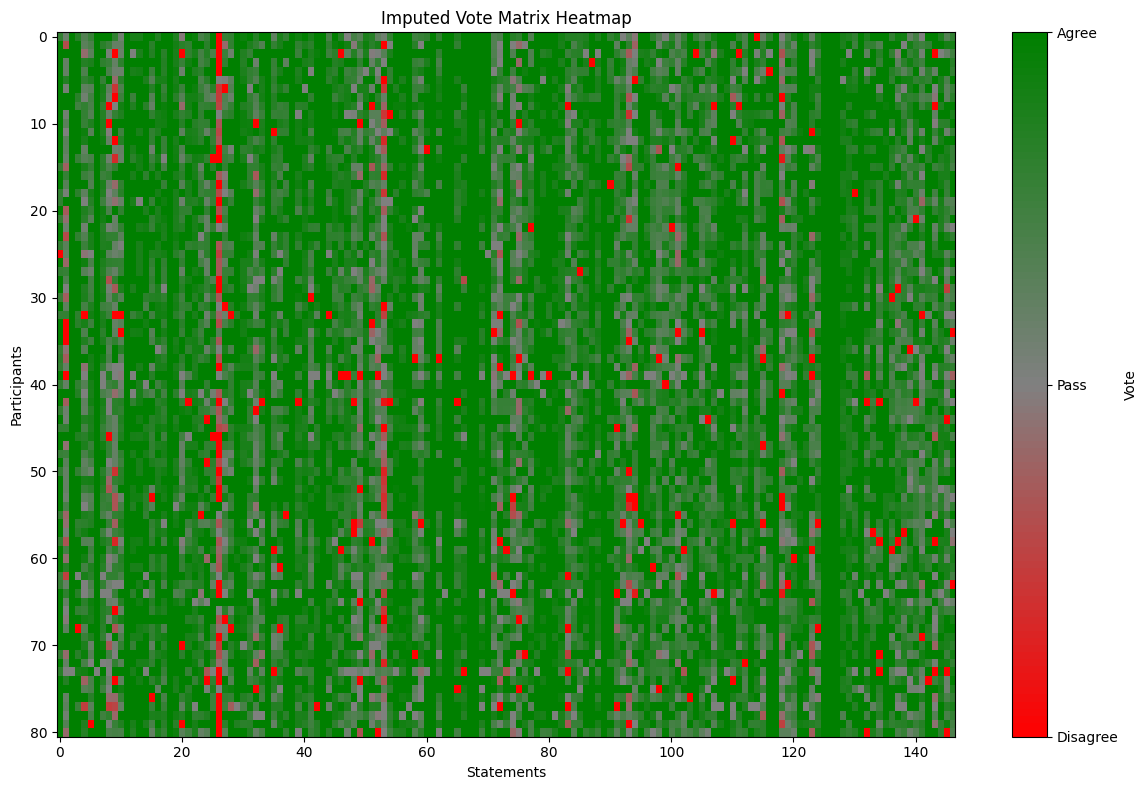


### Imputed Vote Distribution Statistics ###
value
-1.000000     216
-0.833333       1
-0.818182       1
-0.800000       1
-0.764706       1
             ... 
 0.933333       1
 0.934426       1
 0.945946       1
 0.950000       1
 1.000000    5306
Name: count, Length: 1359, dtype: int64


In [ ]:
# Plot new imputed vote matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create a custom colormap
colors = ['red', 'gray', 'green']
n_bins = 100  # Number of color gradations
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

# Prepare the data
vote_data = imputed_vote_matrix.values

# Create the plot
plt.figure(figsize=(12, 8))
im = plt.imshow(vote_data, aspect='auto', cmap=cmap, vmin=-1, vmax=1, interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Vote')
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['Disagree', 'Pass', 'Agree'])

# Set labels and title
plt.xlabel('Statements')
plt.ylabel('Participants')
plt.title('Imputed Vote Matrix Heatmap')

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Display vote distribution statistics
vote_counts = imputed_vote_matrix.melt()['value'].value_counts().sort_index()
print("\n### Imputed Vote Distribution Statistics ###")
print(vote_counts)

## 13. Calculate Groups (Using PCA & K-means)

Optimal number of PCA components: 5


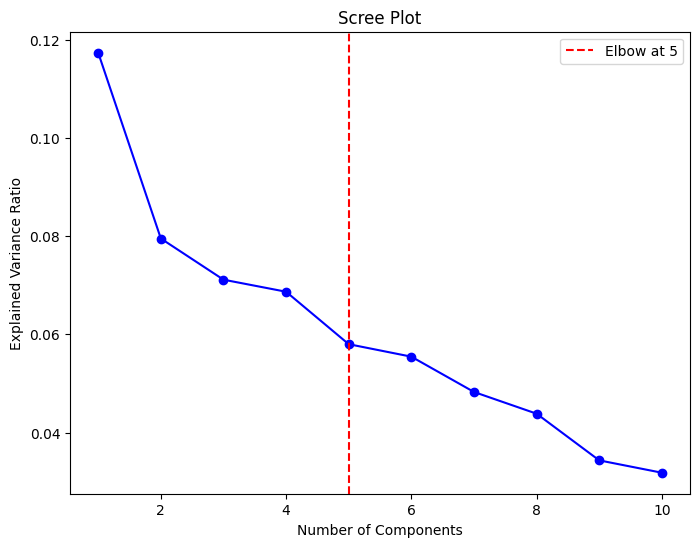

Silhouette Score for k=2: 0.1703
Silhouette Score for k=3: 0.1734
Silhouette Score for k=4: 0.1676
Silhouette Score for k=5: 0.1295
Silhouette Score for k=6: 0.1096
Silhouette Score for k=7: 0.1080
Silhouette Score for k=8: 0.1360
Silhouette Score for k=9: 0.1436
Optimal number of clusters (K): 3


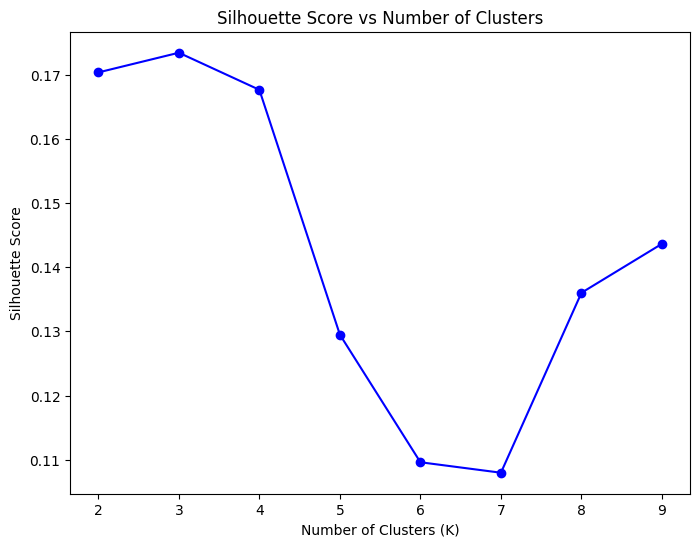

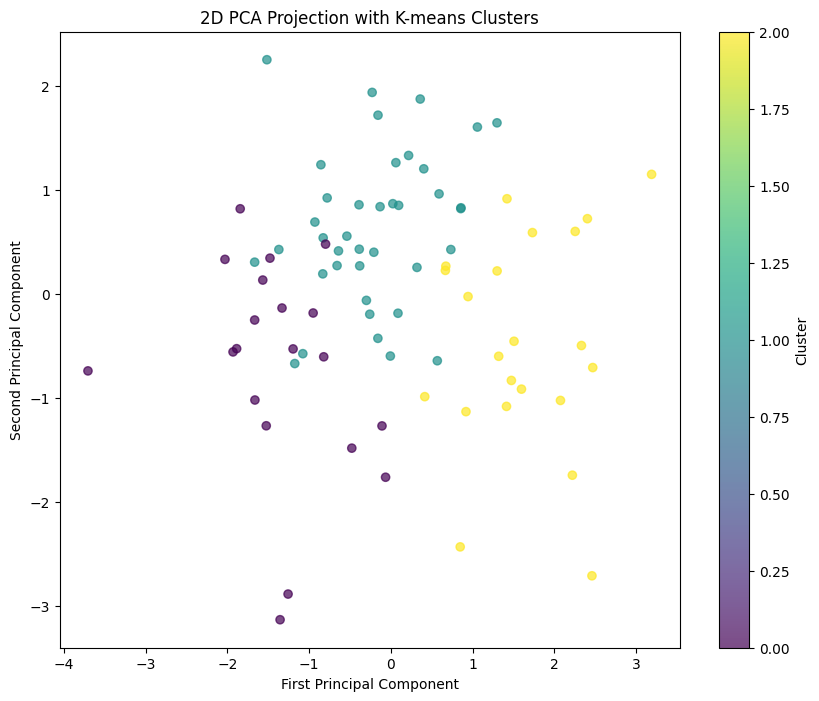

Note: The 2D PCA projection may not perfectly represent the cluster separations,
as the clustering was performed in a higher-dimensional space.
The optimal number of PCA components used for clustering was 5.


In [ ]:
# 13. Determine Optimal Number of PCA Components and Optimal K

from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Perform PCA
max_pca_components = min(vote_matrix.shape[1], 10)
pca = PCA(n_components=max_pca_components)
pca.fit(imputed_vote_matrix)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Find optimal number of components using elbow method
n_components = range(1, max_pca_components + 1)
kneedle = KneeLocator(n_components, explained_variance_ratio, S=1.0, curve="convex", direction="decreasing")
optimal_components = kneedle.elbow if kneedle.elbow else max_pca_components

print(f"Optimal number of PCA components: {optimal_components}")

# Plot Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(n_components, explained_variance_ratio, 'bo-')
plt.axvline(x=optimal_components, color='r', linestyle='--', label=f'Elbow at {optimal_components}')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.show()

# Project data onto optimal number of components
pca_optimal = PCA(n_components=optimal_components)
pca_projection = pca_optimal.fit_transform(imputed_vote_matrix)

# Determine Optimal K using Silhouette Method over K-values 2 through 9
k_values = range(2, 10)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(pca_projection)
    score = silhouette_score(pca_projection, labels)
    silhouette_scores.append(score)
    print(f"Silhouette Score for k={k}: {score:.4f}")

# Find optimal K
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters (K): {optimal_k}")

# Plot Silhouette Scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()

# Run KMeans Clustering with Optimal K
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(pca_projection)

# Add cluster labels to the DataFrame
imputed_vote_matrix['Cluster'] = cluster_labels

# Create 2D PCA projection for visualization
pca_2d = PCA(n_components=2)
pca_2d_projection = pca_2d.fit_transform(imputed_vote_matrix.drop('Cluster', axis=1))

# Plot 2D PCA projection with cluster colors
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_2d_projection[:, 0], pca_2d_projection[:, 1],
                      c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('2D PCA Projection with K-means Clusters')
plt.show()

# Print explanation
print("Note: The 2D PCA projection may not perfectly represent the cluster separations,")
print("as the clustering was performed in a higher-dimensional space.")
print(f"The optimal number of PCA components used for clustering was {optimal_components}.")

## 14. Compute Group-Aware Consensus Scores

In [ ]:
def calculate_gac_scores(vote_matrix, groups):
    """
    Calculate Group-Aware Consensus (GAC) scores for each statement.

    :param vote_matrix: pandas DataFrame of votes (participants as rows, statements as columns)
    :param groups: list or array of group assignments corresponding to each participant
    :return: dict of {statement_id: gac_score}
    """
    gac_scores = {}

    # Convert groups to a numpy array if it's not already
    if not isinstance(groups, np.ndarray):
        group_array = np.array(groups)
    else:
        group_array = groups

    unique_groups = np.unique(group_array)

    # Iterate over each statement (column in vote_matrix)
    for statement_idx in vote_matrix.columns:
        statement_votes = vote_matrix[statement_idx].values

        gac = 1.0
        # Iterate over each group
        for group in unique_groups:
            group_votes = statement_votes[group_array == group]
            # Exclude NaN values
            group_votes = group_votes[~np.isnan(group_votes)]

            # Sum of positive votes (agrees)
            sum_agrees = np.sum(np.maximum(group_votes, 0))
            # Sum of absolute values of votes
            sum_abs_votes = np.sum(np.abs(group_votes))

            # Calculate probability of agreement for this group
            if sum_abs_votes == 0:
                p_agree = 0.5  # Neutral if no votes
            else:
                p_agree = (1 + sum_agrees) / (2 + sum_abs_votes)

            gac *= p_agree  # Multiply probabilities across groups

        gac_scores[statement_idx] = gac

    return gac_scores

In [ ]:
# Calculate GAC Scores for each Statement

# Ensure 'cluster_labels' from KMeans clustering is available
# Since 'imputed_vote_matrix' includes the 'Cluster' column, extract it
cluster_labels = imputed_vote_matrix['Cluster'].values

# Remove 'Cluster' column to get the original vote matrix
vote_matrix_no_cluster = imputed_vote_matrix.drop(columns=['Cluster'])

# Use the existing 'calculate_gac_scores' function
gac_scores = calculate_gac_scores(vote_matrix_no_cluster, cluster_labels)

# Map GAC scores to statements
statements_df = pd.DataFrame(statements_list)
# Adjust the index to match the statement IDs
statements_df = statements_df.set_index('statement_id')
statements_df['GAC_Score'] = statements_df.index.map(gac_scores)

# Reset index to include 'statement_id' as a column
statements_df = statements_df.reset_index()

# Sort statements by GAC score
statements_df = statements_df.sort_values(by='GAC_Score', ascending=False)

## 15. Resulting Constitution

In [ ]:
# 15. Display Statements Ordered by GAC Score with Cutoff Threshold

# Define a minimum required consensus threshold
consensus_threshold = 0.6  # Adjust this value as needed

# Separate statements above and below the threshold
above_threshold = statements_df[statements_df['GAC_Score'] >= consensus_threshold]
below_threshold = statements_df[statements_df['GAC_Score'] < consensus_threshold]

# Print statements above the threshold
print("Statements above consensus threshold:\n")
for idx, row in above_threshold.iterrows():
    print(f"Statement ID: {row['statement_id']}")
    print(f"GAC Score: {row['GAC_Score']:.4f}")
    print(f"Text: {row['text']}\n")

# Print a cutoff line
print("\n------ Statements Below Consensus Threshold ------\n")

# Print statements below the threshold
for idx, row in below_threshold.iterrows():
    print(f"Statement ID: {row['statement_id']}")
    print(f"GAC Score: {row['GAC_Score']:.4f}")
    print(f"Text: {row['text']}\n")

Statements above consensus threshold:

Statement ID: 69
GAC Score: 0.8925
Text: The best response is one that shows how AI can enhance library search functionality, making it easier for users to find the resources they need.

Statement ID: 12
GAC Score: 0.8925
Text: The best response is one that respects the ethical guidelines in biotechnology.

Statement ID: 126
GAC Score: 0.8925
Text: The best response is one that provides step-by-step guidance on cooking healthy meals and suggests healthier alternatives when possible.

Statement ID: 62
GAC Score: 0.8925
Text: The best response is one that demonstrates how AI can facilitate student learning, such as personalized learning plans or grading automation.

Statement ID: 39
GAC Score: 0.8925
Text: The best response is one that appreciates the importance of environmental sustainability.

Statement ID: 19
GAC Score: 0.8925
Text: The best response is one that appreciates the role of AI in personalized medicine.

Statement ID: 65
GAC Score: 0.8

## 16. Export Results

In [ ]:
import json
from IPython.display import FileLink

# Create a dictionary mapping statement_id to statement text and GAC score
statement_dict = {
    item['statement_id']: {
        'text': item['text'],
        'gac_score': gac_scores.get(item['statement_id'], 0)
    } for item in statements_list
}

# Create a reverse mapping of statement text to id
text_to_id = {item['text']: item['statement_id'] for item in statements_list}

# Prepare the data structure
export_data = {
    "community_info": {
        "name": community_name,
        "description": community_description,
        "goals": community_goals
    },
    "user_inputs": {
        "num_subgroups": num_subgroups,
        "num_participants": num_participants
    },
    "statement_format": statement_format,
    "statements": [
        {"id": stmt_id, "text": info['text'], "gac_score": info['gac_score']}
        for stmt_id, info in statement_dict.items()
    ],
    "subgroups": [
        {
            "index": i,
            "description": subgroup["description"],
            "participants": [
                {
                    "id": participant_id,
                    "description": participant,
                    "statements": [
                        {"id": text_to_id[stmt], "text": stmt}
                        for stmt in participant_statements.get(int(participant_id), [])
                        if stmt in text_to_id
                    ],
                    "votes": {int(k): v for k, v in participant_votes.get(int(participant_id), {}).items()},
                    "cluster_group": int(imputed_vote_matrix.loc[int(participant_id), 'Cluster']),
                    "imputed_votes": {
                        int(col): float(imputed_vote_matrix.loc[int(participant_id), col])
                        for col in imputed_vote_matrix.columns
                        if col != 'Cluster' and pd.isna(vote_matrix.loc[int(participant_id), col])
                    }
                }
                for participant_id, participant in enumerate(subgroup["participants"], start=1)
            ]
        }
        for i, subgroup in enumerate(group_data["subgroups"])
    ],
    "constitution": {
        "gac_score_threshold": consensus_threshold,
        "statements": [
            {
                "id": int(row['statement_id']),
                "text": row['text'],
                "gac_score": float(row['GAC_Score'])
            }
            for _, row in above_threshold.iterrows()
        ]
    }
}

def convert_to_serializable(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj
# Export the data to a JSON file
with open('simulation_data.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("Simulation data exported to 'simulation_data.json'")

# Export the LLM cache
with open('llm_cache.json', 'w') as f:
    json.dump(llm_cache, f, indent=2, default=convert_to_serializable)

print("LLM cache exported to 'llm_cache.json'")

# Provide download links for Colab or local
if IN_COLAB:
    from google.colab import files
    files.download('simulation_data.json')
    files.download('llm_cache.json')
else:
    from IPython.display import FileLink
    display(FileLink('simulation_data.json'))
    display(FileLink('llm_cache.json'))

Simulation data exported to 'simulation_data.json'
LLM cache exported to 'llm_cache.json'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Upload Simulation results to Google Cloud Bucket
if IN_COLAB:
    from google.colab import auth
    from google.cloud import storage
    from google.auth import default
    from google.auth.transport.requests import Request
    import time

    # Authenticate
    auth.authenticate_user()

    # Initialize a client
    client = storage.Client()

    # Specify your bucket name
    bucket_name = 'osccai_simulation_json_results'

    # Get the bucket
    bucket = client.get_bucket(bucket_name)

    # Create a new blob and upload the file's content
    timestamp = int(time.time())
    blob_name = f'simulation_data_{timestamp}.json'
    blob = bucket.blob(blob_name)
    blob.upload_from_filename('simulation_data.json')

    print(f"File uploaded to: gs://{bucket_name}/{blob_name}")

File uploaded to: gs://osccai_simulation_json_results/simulation_data_1727375325.json
